In [0]:
!pip install -q kaggle

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c pubg-finish-placement-prediction


 53% 9.00M/16.9M [00:00<00:00, 15.8MB/s]
100% 16.9M/16.9M [00:00<00:00, 31.7MB/s]
 91% 89.0M/98.3M [00:02<00:00, 27.9MB/s]
100% 98.3M/98.3M [00:02<00:00, 45.7MB/s]
 97% 233M/239M [00:04<00:00, 60.2MB/s]
100% 239M/239M [00:04<00:00, 59.0MB/s]


In [0]:
import zipfile
zip_ref = zipfile.ZipFile('sample_submission_V2.csv.zip', 'r')
zip_ref1 = zipfile.ZipFile('test_V2.csv.zip', 'r')
zip_ref2 = zipfile.ZipFile('train_V2.csv.zip', 'r')
zip_ref.extractall()
zip_ref1.extractall()
zip_ref2.extractall()
zip_ref.close()

In [0]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import Imputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from time import time

%matplotlib inline

In [0]:
train_data = pd.read_csv('train_V2.csv')
test_data = pd.read_csv('test_V2.csv')

NameError: ignored

In [0]:
train_data.drop(['Id', 'groupId', 'matchId'], axis=1, inplace=True)
train_data.head()
train_data.info()

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,0,0,0.00,0,0,0,60,1241,0,0,...,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,0,0,91.47,0,0,0,57,0,0,0,...,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1,0,68.00,0,0,0,47,0,0,0,...,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,0,0,32.90,0,0,0,75,0,0,0,...,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,0,0,100.00,0,0,0,45,0,1,1,...,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


In [0]:
train_data.columns

Index(['assists', 'boosts', 'damageDealt', 'DBNOs', 'headshotKills', 'heals',
       'killPlace', 'killPoints', 'kills', 'killStreaks', 'longestKill',
       'matchDuration', 'matchType', 'maxPlace', 'numGroups', 'rankPoints',
       'revives', 'rideDistance', 'roadKills', 'swimDistance', 'teamKills',
       'vehicleDestroys', 'walkDistance', 'weaponsAcquired', 'winPoints',
       'winPlacePerc'],
      dtype='object')

The **kills** feature seems pretty important, practically, for prediction **winPlacePerc** 

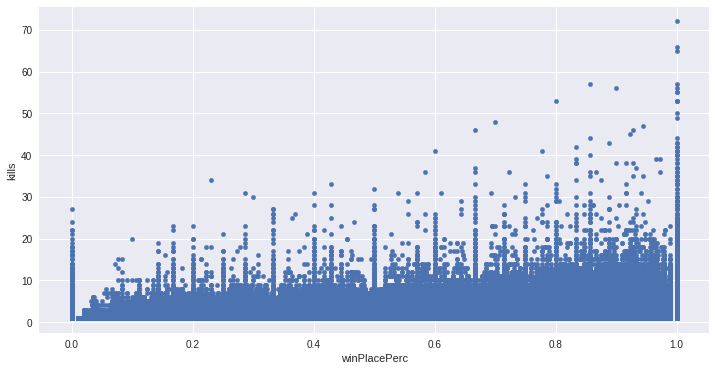

In [0]:
train_data[train_data['kills'] > 0].plot.scatter(x='winPlacePerc', y='kills', figsize=(12, 6))~

As you can see in the above figure, there is a very moderate increase in the slope, which suggests that **kills** has an alright amount of correlation with **winPlacePerc** but also cannot have a high variance.

Let's have a look at the **Heatmap** for more correlation analysis.

[Text(0.5,0,'winPlacePerc'),
 Text(1.5,0,'boosts'),
 Text(2.5,0,'damageDealt'),
 Text(3.5,0,'heals'),
 Text(4.5,0,'kills'),
 Text(5.5,0,'rideDistance'),
 Text(6.5,0,'roadKills'),
 Text(7.5,0,'walkDistance'),
 Text(8.5,0,'weaponsAcquired')]

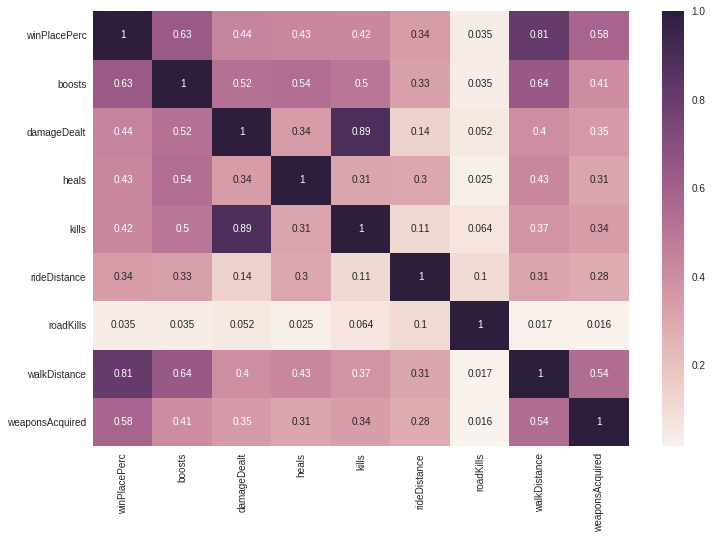

In [0]:
l = ['winPlacePerc', 'boosts', 'damageDealt', 'heals', 'kills', 'rideDistance', 'roadKills', 'walkDistance', 'weaponsAcquired']
figure, ax = plt.subplots(figsize=(12,8))
f = train_data.loc[:, l].corr()
g = sns.heatmap(f, annot=True, ax=ax)
g.set_yticklabels(labels=l[::-1], rotation=0)
g.set_xticklabels(labels=l[:], rotation=90)

Seemingly, **walkDistance**, **boosts** and **weaponsAcquired** have the most correlation with **winPlacePerc**. 

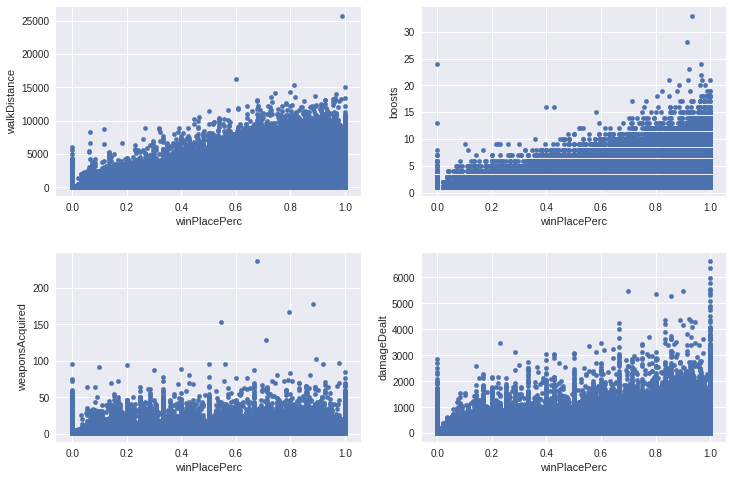

In [0]:
fig, axarr = plt.subplots(2, 2, figsize=(12, 8))
train_data[train_data['walkDistance'] > 0].plot.scatter(x='winPlacePerc', y='walkDistance', ax=axarr[0][0])
train_data[train_data['boosts'] > 0].plot.scatter(x='winPlacePerc', y='boosts', ax=axarr[0][1])
train_data[train_data['weaponsAcquired'] > 0].plot.scatter(x='winPlacePerc', y='weaponsAcquired', ax=axarr[1][0])
train_data[train_data['damageDealt'] > 0].plot.scatter(x='winPlacePerc', y='damageDealt', ax=axarr[1][1])
plt.subplots_adjust(hspace=.3)
sns.despine()

# Data preprocessing

Removing unnecessary features and filling in missing values

In [0]:
train_data.columns

Index(['assists', 'boosts', 'damageDealt', 'DBNOs', 'headshotKills', 'heals',
       'killPlace', 'killPoints', 'kills', 'killStreaks', 'longestKill',
       'matchDuration', 'matchType', 'maxPlace', 'numGroups', 'rankPoints',
       'revives', 'rideDistance', 'roadKills', 'swimDistance', 'teamKills',
       'vehicleDestroys', 'walkDistance', 'weaponsAcquired', 'winPoints',
       'winPlacePerc'],
      dtype='object')

Kaggler ['averagemn'](https://www.kaggle.com/donkeys) pointed out that there is one NaN value in **winPlacePerc**.

In [0]:
train_data[train_data['winPlacePerc'].isnull()]

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
2744604,0,0,0.0,0,0,0,1,0,0,0,...,0,0.0,0,0.0,0,0,0.0,0,0,NaN


In [0]:
train_data.drop(2744604, inplace=True)

**swimDistance** doesn't make much sense, to me, for predicting **winPlacePerc** as swimming distance would generally be much much less than ride distance or walking distance.

But as seen from the figure below, it is pretty useful or maybe that's where everyone's hiding!

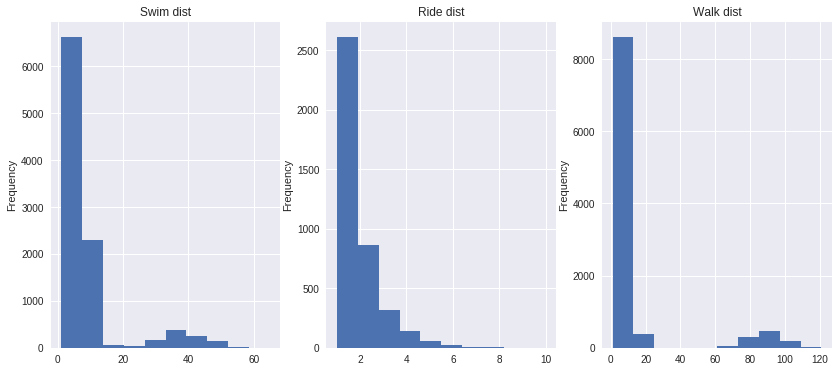

In [0]:
figure1, axarr1 = plt.subplots(1, 3, figsize=(14, 6))
train_data['swimDistance'].value_counts().sort_index()[1:20].plot.hist(ax=axarr1[0])
train_data['rideDistance'].value_counts().sort_index()[1:20].plot.hist(ax=axarr1[1])
train_data['walkDistance'].value_counts().sort_index()[1:20].plot.hist(ax=axarr1[2])
axarr1[0].set_title('Swim dist')
axarr1[1].set_title('Ride dist')
axarr1[2].set_title('Walk dist')
plt.subplots_adjust(hspace=.3)
sns.despine()

In [0]:
train_data['totalDistance'] = train_data['swimDistance'] + train_data['rideDistance'] + train_data['walkDistance']
train_data.drop(['swimDistance', 'rideDistance', 'walkDistance'], axis=1, inplace=True)

In [0]:
train_data['matchType'].value_counts().index

Index(['squad-fpp', 'duo-fpp', 'squad', 'solo-fpp', 'duo', 'solo',
       'normal-squad-fpp', 'crashfpp', 'normal-duo-fpp', 'flaretpp',
       'normal-solo-fpp', 'flarefpp', 'normal-squad', 'crashtpp',
       'normal-solo', 'normal-duo'],
      dtype='object')

In [0]:
# Creating cat codes of match type

train_data['matchType'] = train_data['matchType'].astype('category')
train_data['matchType'] = train_data['matchType'].cat.codes

In [0]:
# Combining boosts and heals as health

train_data['health'] = train_data['boosts'] + train_data['heals']
train_data.drop(['boosts', 'heals'], axis=1, inplace=True)

In [0]:
train_data.head()

,assists,damageDealt,DBNOs,headshotKills,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,...,rankPoints,revives,roadKills,teamKills,vehicleDestroys,weaponsAcquired,winPoints,winPlacePerc,totalDistance,health
0,0,0.00,0,0,60,1241,0,0,0.00,1306,...,-1,0,0,0,0,1,1466,0.4444,244.8000,0
1,0,91.47,0,0,57,0,0,0,0.00,1777,...,1484,0,0,0,0,5,0,0.6400,1445.0445,0
2,1,68.00,0,0,47,0,0,0,0.00,1318,...,1491,0,0,0,0,2,0,0.7755,161.8000,0
3,0,32.90,0,0,75,0,0,0,0.00,1436,...,1408,0,0,0,0,3,0,0.1667,202.7000,0
4,0,100.00,0,0,45,0,1,1,58.53,1424,...,1560,0,0,0,0,2,0,0.1875,49.7500,0


As seen below, most of the kill types are not that varied on their own. So we'll just add those to **kills**

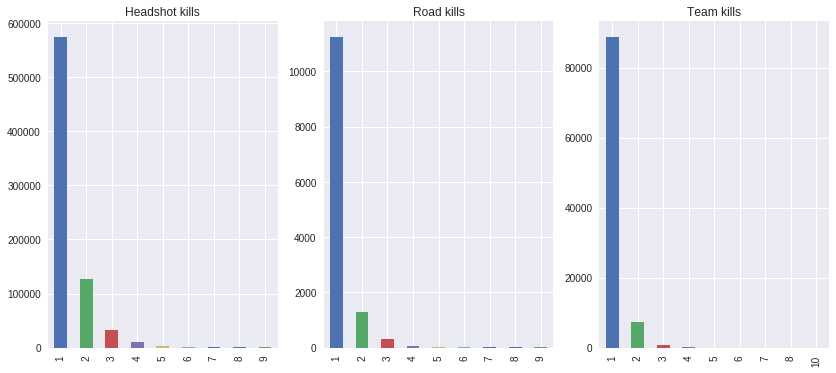

In [0]:
figure2, axarr2 = plt.subplots(1, 3, figsize=(14, 6))
train_data['headshotKills'].value_counts().sort_index().head(10)[1:].plot.bar(ax=axarr2[0])
train_data['roadKills'].value_counts().sort_index().head(10)[1:].plot.bar(ax=axarr2[1])
train_data['teamKills'].value_counts().sort_index().head(10)[1:].plot.bar(ax=axarr2[2])
axarr2[0].set_title('Headshot kills')
axarr2[1].set_title('Road kills')
axarr2[2].set_title('Team kills')
plt.subplots_adjust(hspace=.3)
sns.despine()

In [0]:
train_data['kills'] += train_data['headshotKills'] + train_data['roadKills'] + train_data['teamKills']
train_data.drop(['headshotKills', 'roadKills', 'teamKills'], axis=1, inplace=True)

In [0]:
train_data.head()

,assists,damageDealt,DBNOs,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,vehicleDestroys,weaponsAcquired,winPoints,winPlacePerc,totalDistance,health
0,0,0.00,0,60,1241,0,0,0.00,1306,15,28,26,-1,0,0,1,1466,0.4444,244.8000,0
1,0,91.47,0,57,0,0,0,0.00,1777,15,26,25,1484,0,0,5,0,0.6400,1445.0445,0
2,1,68.00,0,47,0,0,0,0.00,1318,2,50,47,1491,0,0,2,0,0.7755,161.8000,0
3,0,32.90,0,75,0,0,0,0.00,1436,15,31,30,1408,0,0,3,0,0.1667,202.7000,0
4,0,100.00,0,45,0,1,1,58.53,1424,13,97,95,1560,0,0,2,0,0.1875,49.7500,0


# Preprocessing train data

In [0]:
test_data.drop(['Id', 'groupId', 'matchId'], axis=1, inplace=True)

In [0]:
test_data['totalDistance'] = test_data['swimDistance'] + test_data['rideDistance'] + test_data['walkDistance']
test_data.drop(['swimDistance', 'rideDistance', 'walkDistance'], axis=1, inplace=True)

In [0]:
test_data['matchType'] = test_data['matchType'].astype('category')
test_data['matchType'] = test_data['matchType'].cat.codes

In [0]:
test_data['health'] = test_data['boosts'] + test_data['heals']
test_data.drop(['boosts', 'heals'], axis=1, inplace=True)

In [0]:
test_data['kills'] += test_data['headshotKills'] + test_data['roadKills'] + test_data['teamKills']
test_data.drop(['headshotKills', 'roadKills', 'teamKills'], axis=1, inplace=True)

In [0]:
test_data.columns

Index(['assists', 'damageDealt', 'DBNOs', 'killPlace', 'killPoints', 'kills',
       'killStreaks', 'longestKill', 'matchDuration', 'matchType', 'maxPlace',
       'numGroups', 'rankPoints', 'revives', 'vehicleDestroys',
       'weaponsAcquired', 'winPoints', 'totalDistance', 'health'],
      dtype='object')

# Preparing data for ML model

In [0]:
# Mean

fill_NaN = Imputer(missing_values=np.nan, strategy='mean', axis=1)
train_data_mu = pd.DataFrame(fill_NaN.fit_transform(train_data))
train_data_mu.columns = train_data.columns
train_data_mu.index = train_data.index
train_data_mu.head()

,assists,damageDealt,DBNOs,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,vehicleDestroys,weaponsAcquired,winPoints,winPlacePerc,totalDistance,health
0,0.0,0.00,0.0,60.0,1241.0,0.0,0.0,0.00,1306.0,15.0,28.0,26.0,-1.0,0.0,0.0,1.0,1466.0,0.4444,244.8000,0.0
1,0.0,91.47,0.0,57.0,0.0,0.0,0.0,0.00,1777.0,15.0,26.0,25.0,1484.0,0.0,0.0,5.0,0.0,0.6400,1445.0445,0.0
2,1.0,68.00,0.0,47.0,0.0,0.0,0.0,0.00,1318.0,2.0,50.0,47.0,1491.0,0.0,0.0,2.0,0.0,0.7755,161.8000,0.0
3,0.0,32.90,0.0,75.0,0.0,0.0,0.0,0.00,1436.0,15.0,31.0,30.0,1408.0,0.0,0.0,3.0,0.0,0.1667,202.7000,0.0
4,0.0,100.00,0.0,45.0,0.0,1.0,1.0,58.53,1424.0,13.0,97.0,95.0,1560.0,0.0,0.0,2.0,0.0,0.1875,49.7500,0.0


In [0]:
# Median

fill_NaN_1 = Imputer(missing_values=np.nan, strategy='median', axis=1)
train_data_med = pd.DataFrame(fill_NaN_1.fit_transform(train_data))
train_data_med.columns = train_data.columns
train_data_med.index = train_data.index
train_data_med.head()

,assists,damageDealt,DBNOs,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,vehicleDestroys,weaponsAcquired,winPoints,winPlacePerc,totalDistance,health
0,0.0,0.00,0.0,60.0,1241.0,0.0,0.0,0.00,1306.0,15.0,28.0,26.0,-1.0,0.0,0.0,1.0,1466.0,0.4444,244.8000,0.0
1,0.0,91.47,0.0,57.0,0.0,0.0,0.0,0.00,1777.0,15.0,26.0,25.0,1484.0,0.0,0.0,5.0,0.0,0.6400,1445.0445,0.0
2,1.0,68.00,0.0,47.0,0.0,0.0,0.0,0.00,1318.0,2.0,50.0,47.0,1491.0,0.0,0.0,2.0,0.0,0.7755,161.8000,0.0
3,0.0,32.90,0.0,75.0,0.0,0.0,0.0,0.00,1436.0,15.0,31.0,30.0,1408.0,0.0,0.0,3.0,0.0,0.1667,202.7000,0.0
4,0.0,100.00,0.0,45.0,0.0,1.0,1.0,58.53,1424.0,13.0,97.0,95.0,1560.0,0.0,0.0,2.0,0.0,0.1875,49.7500,0.0


In [0]:
y = train_data_mu['winPlacePerc']
X = train_data_mu.drop(['winPlacePerc'], axis=1)
train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.2, random_state=1511)

In [0]:
clf = RandomForestRegressor(n_estimators=100, min_samples_leaf=2, min_samples_split=3, max_features=0.5 ,n_jobs=-1)
t0 = time()
clf.fit(train_X, train_y)
print('Training time', round(time() - t0, 3), 's')
pred = clf.predict(val_X)
print('MAE validation', mean_absolute_error(val_y, pred))

In [0]:
# Mean

fill_NaN_test = Imputer(missing_values=np.nan, strategy='mean', axis=1)
test_data_mu = pd.DataFrame(fill_NaN_test.fit_transform(test_data))
test_data_mu.columns = test_data.columns
test_data_mu.index = test_data.index
test_data_mu.head()

,assists,damageDealt,DBNOs,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,vehicleDestroys,weaponsAcquired,winPoints,totalDistance,health
0,0.0,51.46,0.0,73.0,0.0,0.0,0.0,0.00,1884.0,15.0,28.0,28.0,1500.0,0.0,0.0,1.0,0.0,588.0,0.0
1,0.0,179.10,0.0,11.0,0.0,2.0,1.0,361.90,1811.0,3.0,48.0,47.0,1503.0,2.0,0.0,6.0,0.0,6686.0,6.0
2,1.0,23.40,0.0,49.0,0.0,0.0,0.0,0.00,1793.0,15.0,28.0,27.0,1565.0,0.0,0.0,4.0,0.0,787.8,4.0
3,0.0,65.52,0.0,54.0,0.0,0.0,0.0,0.00,1834.0,3.0,45.0,44.0,1465.0,0.0,0.0,3.0,0.0,1812.0,0.0
4,0.0,330.20,1.0,7.0,0.0,5.0,1.0,60.06,1326.0,15.0,28.0,27.0,1480.0,1.0,0.0,4.0,0.0,2963.0,5.0


In [0]:
pred1 = clf.predict(test_data_mu)

NameError: ignored